In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import f
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

In [2]:
tweet_data = pd.read_csv("/content/vaccination_all_tweets.csv")
vaccination_data = pd.read_csv("/content/vaccinations.csv")

In [3]:
# Группировка данных по дате
grouped_data = vaccination_data.groupby('date')

# Агрегация: подсчет уникальных местоположений и суммирование ежедневной вакцинации
vac_data = grouped_data.agg({'location': 'count', 'daily_vaccinations': 'sum'}).reset_index()

# Переименование столбцов для ясности
vac_data = vac_data.rename(columns={'location': 'counties_count'})

In [4]:
tweet_data['date'] = pd.to_datetime(tweet_data['date'], format='%Y-%m-%d %H:%M:%S')

In [5]:
# Группировка данных по дате
tweet_data = (tweet_data.groupby(tweet_data['date'].dt.date))

# Агрегация: подсчет суммирование ежедневной ретвитов
tweet_data = tweet_data.agg({'retweets': 'sum'})

# Переименование столбцов
tweet_data = tweet_data.reset_index()

In [6]:
df = pd.DataFrame(vac_data)
df["tweets"] = tweet_data["retweets"]

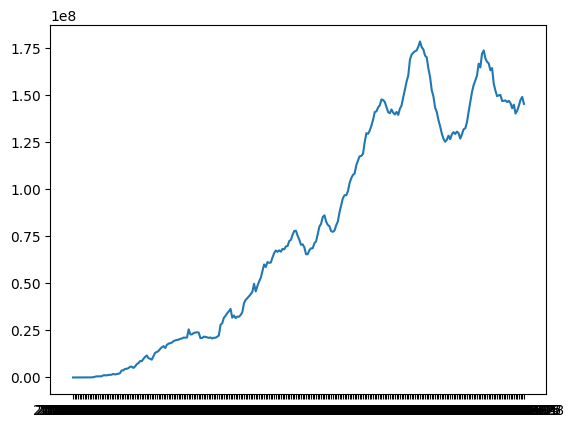

In [14]:
plt.plot(vac_data.date ,vac_data["daily_vaccinations"])

In [7]:
def autoregression(data_series, order, forecast_amount):
    coefficients = np.ones(order)
    lagged_matrix = np.array([data_series[i:order + i] for i in range(len(data_series) - order - 1)])
    coefficients = np.linalg.lstsq(lagged_matrix, data_series[order + 1:len(data_series)], rcond=None)[0]

    data_list = data_series.values.tolist()

    for _ in range(forecast_amount):
        prediction = np.dot(coefficients, data_list[-order:])
        data_list.append(prediction)

    return np.array(data_list)

def combined_autoregression(X_series, Y_series, order_x, order_y, forecast_amount):
    combined_order = order_x + order_y
    combined_coefficients = np.ones(combined_order)

    X_lagged_matrix = np.array([X_series[i:order_x + i] for i in range(len(X_series) - order_x - 1)])
    Y_lagged_matrix = np.array([Y_series[i:order_y + i] for i in range(len(Y_series) - order_y - 1)])

    combined_matrix = np.column_stack((X_lagged_matrix, Y_lagged_matrix))
    combined_coefficients = np.linalg.lstsq(combined_matrix, X_series[order_x + 1:len(X_series)], rcond=None)[0]

    X_list = X_series.values.tolist()
    Y_list = Y_series.values.tolist()

    for _ in range(forecast_amount):
        combined_pred = np.dot(combined_coefficients, X_list[-order_x:] + Y_list[-order_y:])
        X_list.append(combined_pred)

    return np.array(X_list)


In [8]:
daily_vac = df["daily_vaccinations"]
daily_tweet = df["tweets"]


predict_range = 5
lag = len(daily_vac) - predict_range - 2

pred = autoregression(daily_vac[:int(len(daily_vac)) - predict_range], lag ,predict_range)


In [9]:
def granger_causality_test(y_with_lag_residuals, y_without_lag_residuals, lag_order, regression_coefficients, n):

    mse_with_lag = np.mean(y_with_lag_residuals ** 2)
    mse_without_lag = np.mean(y_without_lag_residuals ** 2)

    f_statistic = (abs(mse_without_lag - mse_with_lag) / lag_order) / (mse_with_lag / abs(n - lag_order - regression_coefficients))
    p_value = f.sf(f_statistic, lag_order, n - lag_order - regression_coefficients)

    return f_statistic, p_value


In [10]:
lag_vac = len(daily_vac) - predict_range - 2
predicted_lag_vac = combined_autoregression(daily_vac[:int(len(daily_vac)) - predict_range], daily_tweet[:int(len(daily_vac)) - predict_range], lag_vac, lag_vac, predict_range)

In [11]:
f_statistic, p_value = granger_causality_test(pred, predicted_lag_vac, lag_vac, 2, len(pred)-1)
critical = f.ppf(0.95, 2, len(pred)-1)

print(f"F-статистика: {f_statistic}, P-значение: {p_value}")
print(f'\nТак как {p_value} > 0.05, то мы не можем отвергнуть нулевую гипотезу')



F-статистика: 6.223180866872984e-13, P-значение: 0.9999999999999999

Так как 0.9999999999999999 > 0.05, то мы не можем отвергнуть нулевую гипотезу


In [12]:
daily_vac = df["daily_vaccinations"]

predict_range = 5
lag_tweet = len(daily_vac) - predict_range - 2

daily_tweet = df["tweets"]
predicted_lag_tweet = combined_autoregression(daily_tweet[:int(len(daily_vac)) - predict_range], daily_vac[:int(len(daily_vac)) - predict_range], lag_tweet, lag_tweet, predict_range)

In [13]:
f_statistic, p_value = granger_causality_test(pred, predicted_lag_tweet, lag_tweet, 2, len(pred)-1)
critical = f.ppf(0.95, 2, len(pred)-1)  # Степени свободы для регрессии и остатков

print(f"F-статистика: {f_statistic}, P-значение: {p_value}")
print(f'\nТак как {p_value} > 0.05, то мы не можем отвергнуть нулевую гипотезу')



F-статистика: 0.015209125460696696, P-значение: 0.9999999999999999

Так как 0.9999999999999999 > 0.05, то мы не можем отвергнуть нулевую гипотезу


In [ ]:
#Подведя итог, можно сказать,что количество вакцинаций от ковида не связано с количеством твитов о вакцинации